# Redes Bayesianas

Supongamos una situación en la que tenemos tres variables: **Caries**, **Dolor** y **Huecos**. Por nuestro propio conocimiento, podemos inferir que la caries es la causante del dolor y/o de los huecos en los dientes. Por ese motivo representaremos la red bayesiana con tres nodos, donde el nodo **Caries** es padre de los nodos **Dolor** y **Huecos**. Representaremos en sus respectivas tablas sus valores probabilísticos.

<img src="imgs/red_bayesiana.JPG" width=70%>

Utilizaremos la librería [*pomegranate*](https://pomegranate.readthedocs.io/en/latest/index.html) para crear la red y hacer inferencia sobre ella.

In [29]:
%matplotlib inline
from pomegranate import *

caries = DiscreteDistribution({'Yes': 0.8, 'No': 0.2})

dolor = ConditionalProbabilityTable(
        [['Yes', 'True', 0.6],
         ['Yes', 'False', 0.4],
         ['No', 'True', 0.1],
         ['No', 'False', 0.9]],
         [caries])

huecos = ConditionalProbabilityTable(
        [['Yes', 'True', 0.9],
         ['Yes', 'False', 0.1],
         ['No', 'True', 0.2],
         ['No', 'False', 0.8]],
         [caries])

s1 = Node(caries, name="caries")
s2 = Node(dolor, name="dolor")
s3 = Node(huecos, name="huecos")

model = BayesianNetwork("Dentista")
model.add_states(s1, s2, s3)
model.add_edge(s1, s2)
model.add_edge(s1, s3)

model.bake()
# model.plot()

Populating the interactive namespace from numpy and matplotlib


Calcularemos ahora qué probabilidad de padecer caries tenemos si nos duele una muela.

In [30]:

# observations = { }
# observations = { 'caries' : 'Yes'}
observations = { 'dolor' : 'True', 'huecos': 'True'}

beliefs = model.predict_proba(observations)

for state, belief in zip( model.states, beliefs ):
    if type(belief) is not str:
        print(state.name)
        print("Estado", belief.parameters)

caries
Estado [{'Yes': 0.9908256880733944, 'No': 0.00917431192660559}]


#### Ejercicio 1

Calcula a mano y mediante la librería los siguientes casos:

- Probabilidad de padecer caries tenemos si tenemos huecos.
- Probabilidad de padecer caries.
- Probabilidad de no padecer caries tenemos si tenemos huecos y dolor.
- Probabilidad de tener huecos.

Verifica que lo que calculas a mano coincide con las respuestas de la librería.

#### Ejercicio 2

Implementa mediante la librería la siguiente red:

<img src="imgs/red_bayesiana_ejemplo_2.JPG" width=70%>

Calcula los valores de las diferentes variables si se produce un robo.

In [79]:
%matplotlib inline
from pomegranate import *

robo = DiscreteDistribution({'Yes_robo': 0.001, 'No_robo': 0.999})
terremoto = DiscreteDistribution({'Yes_terremoto': 0.002, 'No_terremoto': 0.998})

alarma = ConditionalProbabilityTable(
        [['Yes_robo', 'Yes_terremoto', 'Salta_alarma', 0.95],
         ['Yes_robo', 'Yes_terremoto', 'No_salta_alarma', 0.05],
         ['Yes_robo', 'No_terremoto', 'Salta_alarma', 0.94],
         ['Yes_robo', 'No_terremoto', 'No_salta_alarma', 0.06],
         ['No_robo', 'Yes_terremoto', 'Salta_alarma', 0.29],
         ['No_robo', 'Yes_terremoto', 'No_salta_alarma', 0.71],
         ['No_robo', 'No_terremoto', 'Salta_alarma', 0.001],
         ['No_robo', 'No_terremoto', 'No_salta_alarma', 0.999]],
         [robo, terremoto])

juan = ConditionalProbabilityTable(
        [['Salta_alarma','Juan_llama', 0.90],
         ['Salta_alarma','Juan_no_llama', 0.10],
         ['No_salta_alarma','Juan_llama', 0.05],
         ['No_salta_alarma','Juan_no_llama', 0.95]],
         [alarma])

maria = ConditionalProbabilityTable(
        [['Salta_alarma','Maria_llama', 0.70],
         ['Salta_alarma','Maria_no_llama', 0.30],
         ['No_salta_alarma','Maria_llama', 0.01],
         ['No_salta_alarma','Maria_no_llama', 0.99]],
         [alarma])

s1 = Node(robo, name="Robo")
s2 = Node(terremoto, name="Terremoto")
s3 = Node(alarma, name="Alarma")
s4 = Node(juan, name="Juan")
s5 = Node(maria, name="Maria")


model = BayesianNetwork("Avisos")
model.add_states(s1, s2, s3, s4, s5)
model.add_edge(s1, s3)
model.add_edge(s2, s3)
model.add_edge(s3, s4)
model.add_edge(s3, s5)

model.bake()
#model.plot()

Populating the interactive namespace from numpy and matplotlib


In [88]:
# observations = {}
observations = {'Robo':'Yes_robo', 'Juan':'Juan_llama'}
# observations = {'Robo':'Yes_robo', 'Juan':'Juan_llama', 'Terremoto':'Yes_terremoto','Maria':'Maria_llama'}
# observations = {'Juan':'Juan_llama', 'Maria':'Maria_llama'}
# observations = {'Alarma' : 'Salta_alarma', 'Juan':'Juan_llama', 'Maria':'Maria_llama'}
# observations = {'Alarma' : 'Salta_alarma', 'Juan':'Juan_llama'}

beliefs = model.predict_proba(observations)

for state, belief in zip( model.states, beliefs ):
    if type(belief) is not str:
        print(state.name)
        print("Estado", belief.parameters)

Terremoto
Estado [{'Yes_terremoto': 0.0020199831098792823, 'No_terremoto': 0.9979800168901206}]
Alarma
Estado [{'No_salta_alarma': 0.003532320318674678, 'Salta_alarma': 0.9964676796813253}]
Maria
Estado [{'Maria_llama': 0.6975626989801145, 'Maria_no_llama': 0.30243730101988553}]


## Redes bayesianas a partir de datos

En un caso normal no contaremos con el DAG (directed acyclid graph) ni con las CPT (conditional probabilisty tables). Tendremos que construir todo eso a partir de los datos que podamos recoger.

El siguiente *script* nos generará un *dataframe* con 100.000 muestras con el que reconstruiremos el ejemplo anterior.

In [81]:
import numpy as np
import pandas as pd

np.random.seed(666)

earthquake = np.random.choice(2, 100000, p=[0.998, 0.002])
robbery = np.random.choice(2, 100000, p=[0.999, 0.001])

alarm = []

for e,r in zip(earthquake, robbery):
    if e==0 and r==0:
        a = np.random.choice(2, p=[0.999, 0.001])
    if e==0 and r==1:
        a = np.random.choice(2, p=[0.06, 0.94])
    if e==1 and r==0:
        a = np.random.choice(2, p=[0.71, 0.29])
    if e==1 and r==1:
        a = np.random.choice(2, p=[0.05, 0.95])
    alarm.append(a)
        
juan = []
maria = []
        
for a in alarm:
    if a==0:
        j = np.random.choice(2, p=[0.95, 0.05])
        m = np.random.choice(2, p=[0.99, 0.01])
    if a==1:
        j = np.random.choice(2, p=[0.10, 0.90])
        m = np.random.choice(2, p=[0.30, 0.70])
    juan.append(j)
    maria.append(m)

aux = np.stack((np.array(earthquake), np.array(robbery), np.array(alarm), np.array(juan), np.array(maria)), axis=0)
samples = np.transpose(aux)

#df = pd.DataFrame(data=samples, columns=["Earthquake", "Robbery", "Alarm", "Juan", "María"])
df = pd.DataFrame(data=samples, columns=["E", "R", "A", "J", "M"])

df

,E,R,A,J,M
0,0,0,0,1,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
99995,0,0,0,0,0
99996,0,0,0,0,0
99997,0,0,0,0,0
99998,0,0,0,0,0


Fíjate que si no contáramos con suficientes datos las probabilidades que calculáramos podrían no ser muy precisas.

In [109]:
print("Porcentaje de veces que hay un robo:", np.round( sum(df['R'])/df.shape[0],4) )

Porcentaje de veces que hay un robo: 0.001


In [110]:
print("Porcentaje de veces que hay un terremoto:", np.round( sum(df['E'])/df.shape[0],4) )

Porcentaje de veces que hay un terremoto: 0.002


In [111]:
print("Porcentaje de veces que suena la alarma y Juan llama:", np.round( sum(df['A'] * df['J']) / sum(df['A']),2) )

Porcentaje de veces que suena la alarma y Juan llama: 0.91


In [112]:
print("Porcentaje de veces que suena la alarma y María llama:", np.round( sum(df['A'] * df['M']) / sum(df['A']),2) )

Porcentaje de veces que suena la alarma y María llama: 0.7


### Creación del DAG

Una vez obtenido el *dataset*, el siguiente paso será crear el DAG. Utilizaremos la librería [bnlearn](https://erdogant.github.io/bnlearn/pages/html/index.html). Para ello haremos:

In [83]:
import bnlearn as bn

DAG = bn.structure_learning.fit(df, methodtype='ex', scoretype='bic')

[bnlearn] >Computing best DAG using [ex]
[bnlearn] >Set scoring type at [bic]


In [84]:
# print adjacency matrix
print(DAG['adjmat'])

target      A      E      J      M      R
source                                   
A       False  False   True   True  False
E        True  False  False  False  False
J       False  False  False  False  False
M       False  False  False  False  False
R        True  False  False  False  False


[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


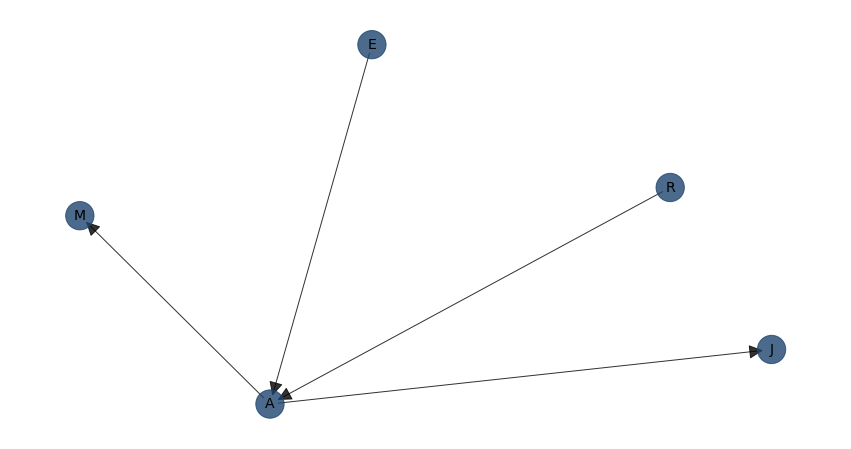

{'pos': {'A': array([-0.43358995, -0.83724467]),
  'E': array([-0.16194989,  1.        ]),
  'J': array([ 0.90291224, -0.55822437]),
  'M': array([-0.94019281,  0.12562049]),
  'R': array([0.6328204 , 0.26984856])},
 'G': <networkx.classes.digraph.DiGraph at 0x10d67bf98>,
 'node_properties': {'A': {'node_color': '#1f456e', 'node_size': 800},
  'E': {'node_color': '#1f456e', 'node_size': 800},
  'J': {'node_color': '#1f456e', 'node_size': 800},
  'M': {'node_color': '#1f456e', 'node_size': 800},
  'R': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('A', 'J'): {'color': '#000000', 'weight': 1},
  ('A', 'M'): {'color': '#000000', 'weight': 1},
  ('E', 'A'): {'color': '#000000', 'weight': 1},
  ('R', 'A'): {'color': '#000000', 'weight': 1}}}

In [85]:
# bn.plot(DAG, interactive=True, params_interactive={'notebook':True})
bn.plot(DAG)

### Aprendizaje de los parámetros

A partir del grafo y de los datos es posible crear las tablas de probabilidad condicionada.

In [86]:
model = bn.parameter_learning.fit(DAG, df, methodtype='maximumlikelihood')

[bnlearn] >Parameter learning> Computing parameters using [maximumlikelihood]
[bnlearn] >Conversion of adjmat to BayesianModel.
[bnlearn] >CPD of A:
+------+-----------------------+--------+--------------------+------+
| E    | E(0)                  | E(0)   | E(1)               | E(1) |
+------+-----------------------+--------+--------------------+------+
| R    | R(0)                  | R(1)   | R(0)               | R(1) |
+------+-----------------------+--------+--------------------+------+
| A(0) | 0.999027159305171     | 0.0625 | 0.7076923076923077 | 0.0  |
+------+-----------------------+--------+--------------------+------+
| A(1) | 0.0009728406948289004 | 0.9375 | 0.2923076923076923 | 1.0  |
+------+-----------------------+--------+--------------------+------+
[bnlearn] >CPD of J:
+------+----------------------+---------------------+
| A    | A(0)                 | A(1)                |
+------+----------------------+---------------------+
| J(0) | 0.9506190165906471   | 0.0897

### Inferencia

In [107]:
# q1 = bn.inference.fit(model, variables=['A','M'], evidence={'R':1, 'J':1})
q1 = bn.inference.fit(model, variables=['A'], evidence={'R':0, 'E':1})
print(q1.df)

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+----------+
|    |   A |        p |
+====+=====+==========+
|  0 |   0 | 0.707692 |
+----+-----+----------+
|  1 |   1 | 0.292308 |
+----+-----+----------+
   A         p
0  0  0.707692
1  1  0.292308


In [108]:
q2 = bn.inference.fit(model, variables=['A'], evidence={'R':1, 'J':1})
print(q2.df)

[bnlearn] >Variable Elimination..


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+----+-----+-----------+
|    |   A |         p |
+====+=====+===========+
|  0 |   0 | 0.0035963 |
+----+-----+-----------+
|  1 |   1 | 0.996404  |
+----+-----+-----------+
   A         p
0  0  0.003596
1  1  0.996404


In [281]:
0.695449+0.300955 

0.996404

### Almacenamiento y carga del modelo

Cuando tenemos gran cantidad de datos y muchas variables, el proceso de encontrar el DAG y calcular las CPT puede ser muy costoso. En ese caso, es necesario contar con funciones para almacenar y recuperar nuestra red bayesiana.

In [299]:
# Save model
bn.save(model, filepath='bnlearn_model', overwrite=True)

# Load model
model = bn.load(filepath='bnlearn_model')

[pypickle] Pickle file saved: [/Users/cayetanoguerraartal/Propio/Docencia/cayetanoguerra.github.io/ia/nbpy/bnlearn_model.pkl]
[pypickle] Pickle file loaded: [/Users/cayetanoguerraartal/Propio/Docencia/cayetanoguerra.github.io/ia/nbpy/bnlearn_model.pkl]


### Ejercicios

1) Calcula las CPTs de las variables *Earthquake* y *Alarm* y comprueba que obtienes los mismos valores que los dados por la librería <code>bn.parameter_learning.fit</code>.

In [106]:
print(np.round( sum((1-df['R']))/df.shape[0],7) )

0.99903


2) Utilizando el dataset "asia", que ya viene incluido en la librería, realiza las siguientes tareas:
- Crear su correspondiente DAG. Prueba otros valores para el parámetro <code>methodtype</code>, como **hc**.
- Calcular las CPT.
- Hacer las inferencias:
    - ¿Qué probabilidad hay de tener disnea siendo fumador?
    - ¿Qué probabilidad hay de tener una radiografía positiva siendo fumador habiendo visitado Asia?
    
La figura siguiente muestra el grafo original. Comprueba que el DAG calculado coincide con éste.

<img src="imgs/ASIA_BN.jpeg" width=40%/>

In [116]:
import bnlearn as bn
df_asia = bn.import_example('asia', n=10000)
print(df_asia)

[bnlearn] >Extracting files..


  0%|          | 0/8 [00:00<?, ?it/s]

      asia  tub  smoke  lung  bronc  either  xray  dysp
0        1    1      0     1      0       1     1     0
1        1    1      0     1      0       1     1     1
2        1    1      0     1      1       1     1     1
3        1    1      1     1      0       1     1     0
4        1    1      0     0      0       0     0     0
...    ...  ...    ...   ...    ...     ...   ...   ...
9995     1    1      1     1      1       1     1     1
9996     1    1      1     1      1       1     1     1
9997     1    1      1     1      1       1     0     1
9998     1    1      0     1      1       1     1     1
9999     1    0      0     1      1       0     0     0

[10000 rows x 8 columns]


## Referencias

https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5